In [2]:
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 

### Helper functions

In [2]:
def distance(xs, centroid):
    """Computes matrix of squared distance from each point to each centroid.
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    
    Returns:
    --------
    distance: matrix of squared distances (nxk)
    """

    distance = np.sum((xs[:,None,:] - centroid)**2, axis=-1)
    return distance

In [3]:
def cost(xs, centroid):
    """Computes the cost of a set of points with respect to a collection of centroids
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    
    Returns:
    --------
    cost: cost with respect to centroids
    """
    #calculate distance to the nearest centroid for each point
    min_dist = np.min(distance(xs, centroid), axis = 1)
    
    #compute cost
    cost = np.sum(min_dist)
    return cost

In [5]:
def centroid_weights(d, centroid):
    """Computes weights as defined in step 7 of the k-means|| algorithm
        
    Parameters:
    -----------
    d : matrix of squared distances (nxk); likely returned from distance() function
    centroid: ndarray of k centroids in d dimensional Euclidean space (kxd)
    
    Returns:
    --------
    w_x: ndarray of weights applied to centroids (kx1)
    """
    #identify closest centroid to each point
    c_close = np.zeros(d.shape)
    c_close[np.range(d.shape[0]), np.argmin(d, axis = 1)] = 1
    
    #compute the weights
    w_x = np.sum(c_close, axis = 0)
    return w_x

### K-means ++ initialization (Section 3.1)

In [ ]:
def k_means_pp(xs, k, seed=None):
    """
    Implements the K_means++ Initialization algorithm
    
    Parameters:
    -----------
    xs: input dataset
    k: the number of output clusters
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    #initialization
    np.random.seed(seed)
    C = xs[np.random.choice(xs.shape[0],1),:]
    loop = 0
    
    while len(C)<k:
        
        if (loop % 10 == 0):
            print("The current loop is:", loop)
        
        dist = distance(xs,C)
        cst = cost(xs,C)
        
        probs_x = np.min(dist, axis = 1)/cst
        C_new = xs[np.random.choice(xs.shape[0],1,p=probs_x),:]
        
        C = np.vstack((C,C_new))
        
        loop += 1
        
    return C

### K-means || initialization (Section 3.3)

In [4]:
def K_Means_parallel(xs, k, l, seed=None):
    """Implements the K_means || algorithm
    
    Parameters:
    -----------
    xs : ndarray of n points in d dimensional Euclidean space (nxd)
    k: the number of output clusters
    l: the oversampling factor; the number of centroids to sample at each iteration
    seed: an optional random seed
    
    Returns:
    --------
    C: the reclustered k centroids used to initialize the k-means algorithm
    """
    
    #initialization
    np.random.seed(seed)
    centroid = xs[np.random.choice(xs.shape[0],1),:]
    order = np.floor(cost(xs,centroid))
    
    ##should we add condition to run minimum # of times unless dataset sufficiently large?
    
    for i in np.arange(np.log10(order)):
        dist = distance(xs,centroid)
        cst = cost(xs,centroid)
        
        probs_x = np.min(dist, axis = 1)/cst
        centroid_new = xs[np.random.choice(xs.shape[0],l,p=probs_x),:]
        
        centroid = np.vstack((centroid,centroid_new))
        
    dist = distance(xs,centroid)
    weight = centroid_weights(dist,centroid)
    
    #Implement k-means++ to recluster weighted points in C
    w_C = weight*centroid
    C = k_means_pp(w_C,k,seed=seed)
    #C = centroid[np.random.choice(centroid.shape[0],k,replace=False,p=weight),:]
    return C

### The Parallel Implementation (Section 3.5)

### Generate GaussMixture synthetic data for testing (Section 4.1)

In [3]:
def GaussMix(R, k, n=10000, d=15, seed=None):
    """Generates GaussMixture synthetic dataset"""
    np.random.seed(seed)
    mu = np.zeros(d)
    sigma = np.diag(R*np.ones(d))
    centers = np.random.multivariate_normal(mean=mu, cov=sigma, size=k)
    
    X,y = make_blobs(n_samples=n, n_features=d, centers=centers, random_state=seed)
    return X,y

In [42]:
GaussMix(10,10)

array([[ 0.58102466,  1.87404547, -0.48184663, -0.09869588],
       [ 3.64098386, -6.39476843,  2.55343764,  1.03594796],
       [ 2.63645793, -0.36173401,  1.33848761, -5.05003076],
       [ 1.22581549, -3.02682932, -0.3501024 ,  0.57000393],
       [-4.87250918,  0.90725194, -2.93065274,  0.01008257],
       [-6.83536658, -0.34254071,  2.57151817,  0.34701268],
       [-1.19485905,  2.43665718, -6.45244466,  1.24806639],
       [-2.04093192, -0.83646855, -3.60786288, -0.14984121],
       [ 1.70858059,  0.76762292, -2.91451888, -5.29702327],
       [ 0.80896615, -1.27420734, -0.26550348, -0.28302093]])

In [66]:
set(GaussMix(10,10)[1])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

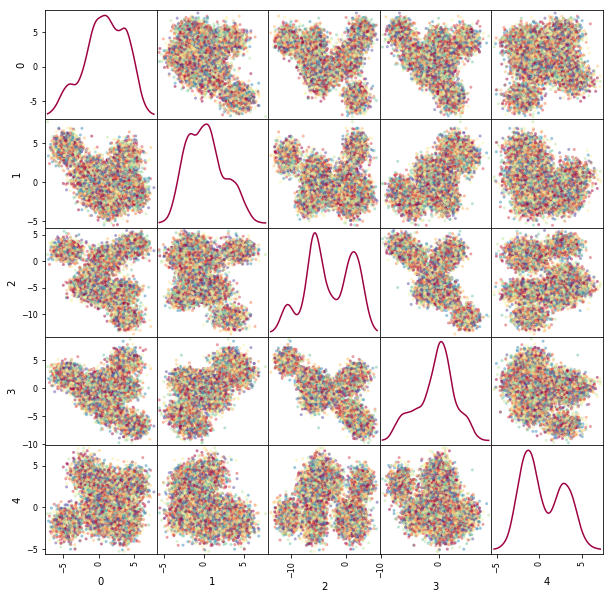

In [50]:
df = pd.DataFrame(GaussMix(10,10)[0])
y = GaussMix(10,10)[1]
pd.plotting.scatter_matrix(df.iloc[:,0:5], c=y, figsize=(10,10),
                           diagonal='kde', alpha=0.5, cmap='Spectral')
pass